## NLP  for Fake News Detection

In [29]:
import pandas as pd
import numpy as np
from IPython.display import display
import seaborn as sns
import matplotlib.pyplot as plt

In [30]:
train = pd.read_csv('https://storage.googleapis.com/temporarystorageglobal/1stAssignmentTextClassification/fake_or_real_news_training.csv')
test = pd.read_csv('https://storage.googleapis.com/temporarystorageglobal/1stAssignmentTextClassification/fake_or_real_news_test.csv')

In [31]:
print("Train Shape:", train.shape, "\n Test Shape:", test.shape)
train.sample(5)
#test.sample(5)

Train Shape: (3999, 6) 
 Test Shape: (2321, 3)


,ID,title,text,label,X1,X2
2679,5148,How 2016 became the fact-check election,Spin and overstatement have long been a part o...,REAL,NaN,NaN
603,5871,SHOCK: NSA Can Recover ALL of Hillary’s Delete...,REPORT: Hillary’s Friends Told To Lie About He...,FAKE,NaN,NaN
3047,4334,"Trump Doubles Down On McCain Criticism, Refusi...","Trump Doubles Down On McCain Criticism, Refusi...",REAL,NaN,NaN
1481,4188,The Republican Party ruined conservatism long ...,This is true at both the national and state le...,REAL,NaN,NaN
2155,7646,Report: It Still Nowhere Near Okay To Act Like...,Report: It Still Nowhere Near Okay To Act Like...,FAKE,NaN,NaN


## 1. Data Cleaning

In [32]:
#X2 does not seem to be of much use - it mostly contains NaN values
here=train[train["X2"].notnull()]
here

#replace mislabelled data with available labels in X2
train.loc[train.text.isin(here.text), ['label']] = here.loc[here.text.isin(train.text),['X2']].values

#checking X1 for mislabelled data
here_2=train[train["X1"].notnull()]

#replace mislabelled data with available labels in X1
train.loc[train.text.isin(here_2.text), ['label']] = here_2.loc[here_2.text.isin(here_2.text),['X1']].values

#Checking X2 again - in here_3 we see that some labels do not contain REAL/FAKE labels but rather other text
here_3=train[train["X2"].notnull()]
train.loc[train.text.isin(here_3.text), ['label']] = here_3.loc[here_3.text.isin(here_2.text),['X2']].values

train.drop(['X1', 'X2'], axis=1, inplace=True)
train.sample(5)

,ID,title,text,label
3404,2698,Fox News Eats Its Own,The Republican National Committee triumphantly...,REAL
2450,7580,BREAKING: FBI Gets Search Warrant For State De...,BREAKING: FBI Gets Search Warrant For State De...,FAKE
3351,161,Congress likely to blow budget deadline,"Asked what Trump will do while in Florida, spo...",REAL
2601,8739,Syria conflict: Food rations run out in rebel-...,"November 11, 2016 Syria conflict: Food rations...",FAKE
3849,2079,Obama pledges faster action on new icebreakers...,President Obama wants to accelerate by two yea...,REAL


/usr/local/envs/py3env/lib/python3.5/site-packages/seaborn/categorical.py:1424: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)
/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


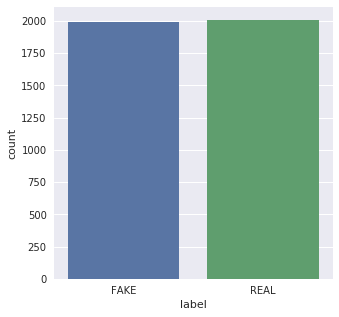

In [33]:
# extracting the number of examples of each class
real = train[train['label'] == 'REAL'].shape[0]
fake = train[train['label'] == 'FAKE'].shape[0]

#Checking distribution
sns.countplot('label', data = train)
plt.rcParams["figure.figsize"] = (5,5)
plt.show()

## 2. NLP Tasks and Modelling

In [34]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer


In [35]:
train['label'] = train['label'].map( {'REAL':0, 'FAKE':1} )

In [36]:

test['complete']=test['title']+" "+test['text']

In [37]:

train['complete']=train['title']+" "+train['text']

In [38]:
transformer = TfidfTransformer(smooth_idf=False)
count_vectorizer = CountVectorizer(ngram_range=(1, 2))
counts = count_vectorizer.fit_transform(train['complete'].values)
tfidf = transformer.fit_transform(counts)

In [39]:
targets = train['label'].values
test_counts = count_vectorizer.transform(test['complete'].values)
test_tfidf = transformer.fit_transform(test_counts)


/usr/local/envs/py3env/lib/python3.5/site-packages/sklearn/feature_extraction/text.py:1067: RuntimeWarning: divide by zero encountered in true_divide
  idf = np.log(float(n_samples) / df) + 1.0


In [40]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(tfidf, targets, random_state=0)

In [51]:
from sklearn.linear_model import PassiveAggressiveClassifier
model_p = PassiveAggressiveClassifier(n_iter=1000, random_state=40)
model_p.fit(X_train,y_train)
print('Accuracy of classifier on training set: {:.2f}'
     .format(model_p.score(X_train, y_train)))
print('Accuracy of classifier on test set: {:.2f}'
     .format(model_p.score(X_test, y_test)))

/usr/local/envs/py3env/lib/python3.5/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Accuracy of classifier on training set: 1.00
Accuracy of classifier on test set: 0.92


In [70]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(penalty='l2', C=1e5)
logreg.fit(X_train, y_train)
print('Accuracy of classifier on training set: {:.2f}'
     .format(logreg.score(X_train, y_train)))
print('Accuracy of classifier on test set: {:.2f}'
     .format(logreg.score(X_test, y_test)))

Accuracy of classifier on training set: 1.00
Accuracy of classifier on test set: 0.92


In [73]:
targets = train['label'].values
logreg = LogisticRegression()
logreg.fit(counts, targets)

example_counts = count_vectorizer.transform(test['complete'].values)
predictions = logreg.predict(example_counts)
pred=pd.DataFrame(predictions,columns=['label'])
pred['ID']=test['ID']
pred.groupby('label').count()

,ID
label,
0,1151
1,1170


In [75]:
pred.sample(5)

,label,ID
685,1,8770
1053,1,8050
135,1,9543
338,0,1221
2172,1,10181


In [76]:
pred.to_csv('output_predictions.csv', index=False)

### encoded '1' as Fake and '0' as Real News. 

### Additional models; can use for Ensembling

In [56]:
from xgboost import XGBClassifier

/usr/local/envs/py3env/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [57]:
xgb_model = XGBClassifier()

In [58]:
xgb_model.fit(X_train, y_train)
print('Accuracy of classifier on training set: {:.2f}'
     .format(logreg.score(X_train, y_train)))
print('Accuracy of classifier on test set: {:.2f}'
     .format(logreg.score(X_test, y_test)))

Accuracy of classifier on training set: 1.00
Accuracy of classifier on test set: 0.92


In [41]:
from sklearn.ensemble import AdaBoostClassifier

In [42]:
from sklearn.tree import DecisionTreeClassifier

Adab= AdaBoostClassifier(DecisionTreeClassifier(max_depth=3),n_estimators=5)
Adab.fit(X_train, y_train)
print('Accuracy of Adaboost classifier on training set: {:.2f}'
     .format(Adab.score(X_train, y_train)))
print('Accuracy of Adaboost classifier on test set: {:.2f}'
     .format(Adab.score(X_test, y_test)))

Accuracy of Adaboost classifier on training set: 0.87
Accuracy of Adaboost classifier on test set: 0.84


In [44]:
from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier,
                              AdaBoostClassifier)

Extr = ExtraTreesClassifier(n_estimators=5,n_jobs=4)
Extr.fit(X_train, y_train)
print('Accuracy of ExtrTrees classifier on training set: {:.2f}'
     .format(Extr.score(X_train, y_train)))
print('Accuracy of Extratrees classifier on test set: {:.2f}'
     .format(Extr.score(X_test, y_test)))

Accuracy of ExtrTrees classifier on training set: 1.00
Accuracy of Extratrees classifier on test set: 0.80


In [45]:
Rando= RandomForestClassifier(n_estimators=5)

Rando.fit(X_train, y_train)
print('Accuracy of randomforest classifier on training set: {:.2f}'
     .format(Rando.score(X_train, y_train)))
print('Accuracy of randomforest classifier on test set: {:.2f}'
     .format(Rando.score(X_test, y_test)))

Accuracy of randomforest classifier on training set: 0.99
Accuracy of randomforest classifier on test set: 0.78


In [46]:
from sklearn.naive_bayes import MultinomialNB

NB = MultinomialNB()
NB.fit(X_train, y_train)
print('Accuracy of NB  classifier on training set: {:.2f}'
     .format(NB.score(X_train, y_train)))
print('Accuracy of NB classifier on test set: {:.2f}'
     .format(NB.score(X_test, y_test)))

Accuracy of NB  classifier on training set: 0.89
Accuracy of NB classifier on test set: 0.70


## Conclusion: Used LR model with Test Accuracy of 92% for generating predictions on test set. Will shortly be ensembling the above models to try and get better classification accuracy.